# The well-knowns: text and binary

Two related formats for representing geospatial vectors are Well-Known Text (WKT) and Well-Known Binary (WKB). Let's take a look at these formats as WKB in particular will be important once we get to GeoParquet.

## What are WKT and WKB?

### WKT

WKT is a simple text format for geometries. It's basically the stripped-down version of GeoJSON's geometry structure. Three examples follow of a point, line, and polygon geometry.

* Point geometry
  * GeoJSON

    ```json
    {
        "type": "Point",
        "coordinates": [53, 5]
    }
    ```

  * WKT: `POINT(53 5)`
* Line geometry
  * GeoJSON

    ```json
    {
        "type": "LineString",
        "coordinates": [
            [30, 10],
            [10, 30],
            [40, 40]
        ]
    }
    ```

  * WKT: `LINESTRING(30 10, 10 30, 40 40)`
* Polygon geometry
  * GeoJSON

    ```json
    {
        "type": "Polygon",
        "coordinates": [[
            [0, 0],
            [4, 0],
            [4, 4],
            [0, 4],
            [0, 0]
        ]]
    }
    ```

  * WKT: `POLYGON((0 0, 4 0, 4 4, 0 4, 0 0))`

Notice: geometry type keyword, then coordinates in parentheses. No nesting, no attributes—just the geometry. In both cases notice the coordinate pair order is `X, Y`, which in WGS84 (EPSG:4326) makes these coordinates `longitude, latitude` order. Notably, WKT can express coordinates in any CRS: unlike GeoJSON post-RFC 7946, it is not limited to just WGS84 coordinates. The CRS reference must be supplied separately, typically Spatial Reference Identifier (SRID) metadata or external documentation; OGC defines two WKT formats for CRS representations, which are not to be confused with the WKT format for geometries we are discussing here.

### WKB

WKB encodes the exact same structure as WKT, but in binary format to increase the compactness of the representation at the cost of human readability. For any geometry, its WKB contains:

* Byte order marker (1 byte): 0x01 for little-endian, 0x00 for big-endian
* Geometry type code (4-byte integer): 1=Point, 2=LineString, 3=Polygon, etc.
* Geometry data: Structure depends on type

Point coordinates are encoded as a pair of double-precision float values (8 bytes each). When the geometry type is a compound type (LineString, Polygon...) then it is also necessary to list the number of fields in that type, i.e., how many points are in a line, how many rings are in the polygon.

Our polygon example `POLYGON((0 0, 4 0, 4 4, 0 4, 0 0))`, for instance, could look like this (written in hex-format bytes):

```
01                                                # Endianness (little)
03 00 00 00                                       # Geometry type: 3 (Polygon)  
01 00 00 00                                       # Number of rings: 1
05 00 00 00                                       # Number of points in ring 0: 5
00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  # Point 0: (0.0, 0.0)
00 00 00 00 00 00 10 40  00 00 00 00 00 00 00 00  # Point 1: (4.0, 0.0)
00 00 00 00 00 00 10 40  00 00 00 00 00 00 10 40  # Point 2: (4.0, 4.0)
00 00 00 00 00 00 00 00  00 00 00 00 00 00 10 40  # Point 3: (0.0, 4.0)
00 00 00 00 00 00 00 00  00 00 00 00 00 00 00 00  # Point 4: (0.0, 0.0)
```

Now in this trivial example, the representation is not actually more compact than the WKT representation. With real-world coordinate values like `174.76536299052356`, the WKB representation ends up 2-3× smaller than the WKT string representation before compression (of course, if you are asking "why 64-bit double floats instead of fixed precision values": don't get me started, I don't understand it either--I can only think early GIS software used floats and the inertia continues to this day).

But the data size is not the real benefit of WKB: it's actually the parsing speed that really matters. It is much more efficient to take these binary values and unpack them directly into numeric types without string-to-float conversion, handling delimiters, etc. At scale with millions of geometries this makes a massive difference.

WKB actually comes in three flavors: standard, extended, and ISO. In short, extended and ISO allow for the specification of additional coordinate values in the case of Z or M values. Extended also allows for the optional specification of an SRID. More on the WKB spec can be gleaned from the [libgeos documentation](https://libgeos.org/specifications/wkb/).

## Is this a CNG format? Why do we care?

Great question! No, this WKT and WKB are decidedly not CNG formats. They're not really data formats themselves, they just define how to encode geometries in text and binary formats, respectively. So we don't generally use WKT or WKB by themselves, but as a way to represent a geometry in a larger data object or file. This is exactly why we need to talk about them, because GeoParquet (which we'll look at in the next exercise) uses WKB encoding to store geometries. This exercise is really just a necessary prerequisite to help us make the jump from the easy-and-human-readable-but-not-CNG GeoJSON format to the much more complex GeoParquet format by preparing us for what we'll be reading out of a GeoParquet's geometry column.

## The exercise

Before we get too far, let's get some imports out of the way.

In [40]:
import struct

from shapely import from_wkb as shapely_from_wkb, wkt as shapely_wkt

### WKT encoding

Now, let's start by dropping our geometry from our feature from exercise 1 here so we have a GeoJSON-format geometry to convert to WKT.

In [12]:
#| scrub-note: geom_str = '''PASTE YOUR GEOJSON GEOMETRY HERE'''
geom_str = '''{
    "coordinates": [[
        [174.76536299052356, -36.85325730119731],
        [174.76501948066357, -36.85354934760823],
        [174.76510987799577, -36.853728372411425],
        [174.76557768418712, -36.85354844344181],
        [174.76544321815658, -36.85331878474462],
        [174.76536299052356, -36.85325730119731]
    ]],
    "type": "Polygon"
}'''

Now, let's write this Polygon geometry out in WKT format by hand.

In [13]:
#| scrub-note: wkt = 'WRITE YOUR WKT POLYGON HERE'
wkt = 'POLYGON((174.76536299052356 -36.85325730119731, 174.76501948066357 -36.85354934760823, 174.76510987799577 -36.853728372411425, 174.76557768418712 -36.85354844344181, 174.76544321815658 -36.85331878474462, 174.76536299052356 -36.85325730119731))'
wkt

'POLYGON((174.76536299052356 -36.85325730119731, 174.76501948066357 -36.85354934760823, 174.76510987799577 -36.853728372411425, 174.76557768418712 -36.85354844344181, 174.76544321815658 -36.85331878474462, 174.76536299052356 -36.85325730119731))'

We can use shapely's `wkt` module (imported as `shapely_wkt`) to validate our WKT representation.

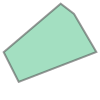

In [17]:
shapely_wkt.loads(wkt)

Did that work? Did you get an exception? Does the resulting geometry look correct? Repeat until you get this correct.

### WKB encoding

Our next step is to convert our WKT into WKB. We initially converted our GeoJSON to WKT because WKT is much closer to WKB in format, so we should be able to take our WKT and more or less encode it directly to WKB manually. We'll use the python `struct` module to help us pack native Python values into the WKB binary structure, which should help with the hard parts.

To proceed, need to define some variables:

* `endianness`: the endianness we want to use. Set this to `0` for big, `1` for little.
* `geom_type`: the integer ID of our geometry type.
* `ring_count`: how many rings we have in our geometry. This should be `1` -- if you have more than one ring just use one for simplicity.
* `ring_points`: a list of two-tuples with our (x, y) coordinate values.

In [60]:
#| scrub-note: # DEFINE THE ABOVE VARIABLES HERE FOR YOUR GEOMETRY
endianness = 1
geom_type = 3
ring_count = 1
ring_points = [
    (174.76536299052356, -36.85325730119731),
    (174.76501948066357, -36.85354934760823),
    (174.76510987799577, -36.853728372411425),
    (174.76557768418712, -36.85354844344181),
    (174.76544321815658, -36.85331878474462),
    (174.76536299052356, -36.85325730119731),
]

#### A quick note about `struct`

If you haven't used `struct` before, it is a Python stdlib module to assist with packing an unpacking binary values. Imagine a byte string encoding several integers: struct can unpack them into native Python types. It can also pack native Python types into a byte string. Here are some examples:

In [61]:
# packing four Python int type values into uint32 values
# we specify the endianness explicitly, with `<` meaning little
bytes_ = struct.pack('<IIII', 4, 8, 16, 32)
bytes_

b'\x04\x00\x00\x00\x08\x00\x00\x00\x10\x00\x00\x00 \x00\x00\x00'

In [62]:
# struct supports a variety of types
struct.unpack('<bbbbHHHHI', bytes_)

(4, 0, 0, 0, 8, 0, 16, 0, 32)

In [63]:
# look what happens if we do the same with big endianness
struct.unpack('>bbbbHHHHI', bytes_)

(4, 0, 0, 0, 2048, 0, 4096, 0, 536870912)

Notice how interpreting the same bytes with different endianness gives completely wrong values? This is why WKB's first byte matters!

The above is a really quick primer. The [`struct` documentation](https://docs.python.org/3/library/struct.html) is great and provides a lot more info about the module. It also has a handy table of all the different format characters it supports and the different data types they represent.

### Back to WKB

Now that we understand how to use `struct`, we can pack the variables we defined into a WKB byte string. Note that:

* `endianness` is stored as an unsigned byte, `struct` type `B`. It also defines the endianness we need to specify when packing: `<` if `bool(endianness)` (little) else `>`.
* `geom_type` and `ring_count` are uint32, `struct` type `I`.
* We can use `len(ring_points)` to get the number of points in our ring, which is also encoded as a uint32 via `I`.
* Each coordinate value in `ring_points` is a double float, or `d`. We can write `d` repeated for the number of values we need to encode, like `dddd` if we had four coordinate values across two points (two coordinate pairs). We could also use the shorter equivalent of specifying the number of values then `d`, like `4d` in the previous example.

In [64]:
#| scrub-note: wkb = struct.pack(\n    'FILL IN THE FORMAT CODE',\n    endianness,\n    geom_type,\n    ring_count,\n    len(ring_points),\n    *(c for pair in ring_points for c in pair),\n)
wkb = struct.pack(
    f'{"<" if endianness else ">"}BIII{len(ring_points)*2}d',
    endianness,
    geom_type,
    ring_count,
    len(ring_points),
    *(c for pair in ring_points for c in pair),
)

In [65]:
wkb.hex()

'01030000000100000006000000c2bb86da7dd865409bdb0589376d42c01848220a7bd86540efbfe21a416d42c0d4fab5c77bd865405296a7f8466d42c03284c59c7fd8654030114d13416d42c0ae9dc6827ed8654033c5c88c396d42c0c2bb86da7dd865409bdb0589376d42c0'

We can use shapely to validate our WKB encoding using its `from_wkb` function, here imported as `shapely_from_wkb`.

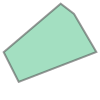

In [66]:
shapely_from_wkb(wkb)

Did that work? Did you get an exception? Does the resulting geometry look correct? Iterate above until you get this correct.